In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 469 ms
Wall time: 479 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

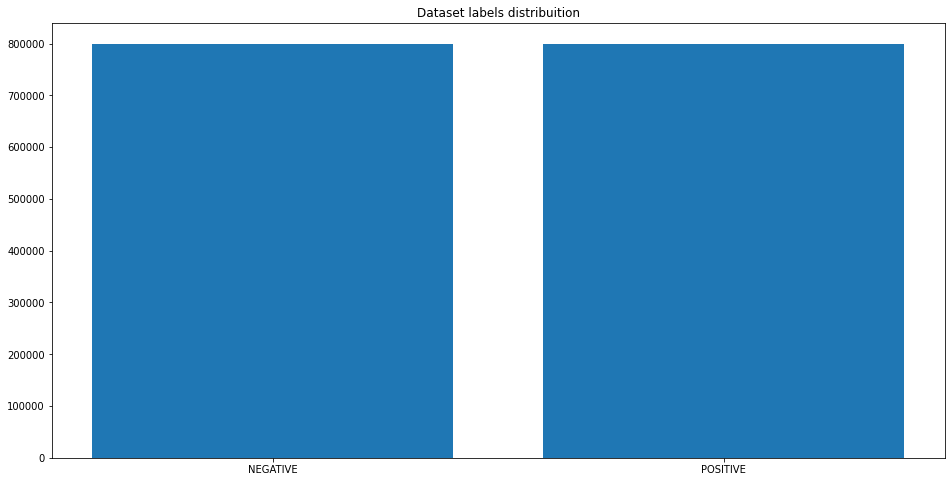

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [62]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words and ['no','not']:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 50.8 s
Wall time: 51.1 s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 2.84 s
Wall time: 2.88 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

2022-02-15 12:03:51,169 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2022-02-15T12:03:51.168944', 'gensim': '4.1.2', 'python': '3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}


In [17]:
w2v_model.build_vocab(documents)

2022-02-15 12:04:10,468 : INFO : collecting all words and their counts
2022-02-15 12:04:10,469 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-15 12:04:10,487 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-02-15 12:04:10,506 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-02-15 12:04:10,525 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-02-15 12:04:10,543 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-02-15 12:04:10,560 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-02-15 12:04:10,579 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-02-15 12:04:10,598 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-02-15 12:04:10,619 : INFO : PROGRESS: at s

2022-02-15 12:04:11,943 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2022-02-15 12:04:11,969 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2022-02-15 12:04:11,989 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2022-02-15 12:04:12,011 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2022-02-15 12:04:12,030 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2022-02-15 12:04:12,050 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2022-02-15 12:04:12,070 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2022-02-15 12:04:12,091 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2022-02-15 12:04:12,112 : INFO : PROGRESS: at sentence #800000, processed 577088

2022-02-15 12:04:13,944 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2022-02-15T12:04:13.944717', 'gensim': '4.1.2', 'python': '3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'build_vocab'}


In [18]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-02-15 12:05:47,009 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-02-15T12:05:47.009056', 'gensim': '4.1.2', 'python': '3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'train'}
2022-02-15 12:05:48,031 : INFO : EPOCH 1 - PROGRESS: at 17.13% examples, 1401946 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:05:49,035 : INFO : EPOCH 1 - PROGRESS: at 35.42% examples, 1450926 words/s, in_qsize 16, out_qsize 1
2022-02-15 12:05:50,059 : INFO : EPOCH 1 - PROGRESS: at 54.14% examples, 1469237 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:05:51,061 : INFO : EPOCH 1 - PROGRESS: at 71.45% examples, 1457805 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:05:52,079 : INFO : EPOCH 1 - PROGRESS: at 88.91% examples, 1447492 words/s, in_qsize 15, ou

2022-02-15 12:06:20,901 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-02-15 12:06:20,902 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-02-15 12:06:20,905 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-02-15 12:06:20,909 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-02-15 12:06:20,915 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-02-15 12:06:20,917 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-15 12:06:20,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-15 12:06:20,922 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-15 12:06:20,923 : INFO : EPOCH - 6 : training on 9227204 raw words (8222834 effective words) took 5.7s, 1440991 effective words/s
2022-02-15 12:06:21,945 : INFO : EPOCH 7 - PROGRESS: at 16.38% examples, 1341597 words/s, in_qsize 14, out_qsize 1
2022-02-15 12:06:22

2022-02-15 12:06:51,118 : INFO : EPOCH 12 - PROGRESS: at 34.68% examples, 1409228 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:06:52,120 : INFO : EPOCH 12 - PROGRESS: at 51.96% examples, 1413787 words/s, in_qsize 14, out_qsize 1
2022-02-15 12:06:53,125 : INFO : EPOCH 12 - PROGRESS: at 70.91% examples, 1448214 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:06:54,133 : INFO : EPOCH 12 - PROGRESS: at 88.81% examples, 1449972 words/s, in_qsize 15, out_qsize 3
2022-02-15 12:06:54,678 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-02-15 12:06:54,683 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-02-15 12:06:54,686 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-02-15 12:06:54,687 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-02-15 12:06:54,692 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-02-15 12:06:54,695 : INFO : worker thread finished; awaiting finish of 2 mor

2022-02-15 12:07:22,719 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-15 12:07:22,723 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-15 12:07:22,723 : INFO : EPOCH - 17 : training on 9227204 raw words (8223008 effective words) took 5.6s, 1470564 effective words/s
2022-02-15 12:07:23,764 : INFO : EPOCH 18 - PROGRESS: at 15.41% examples, 1261937 words/s, in_qsize 11, out_qsize 4
2022-02-15 12:07:24,790 : INFO : EPOCH 18 - PROGRESS: at 33.16% examples, 1343990 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:07:25,815 : INFO : EPOCH 18 - PROGRESS: at 50.24% examples, 1353996 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:07:26,846 : INFO : EPOCH 18 - PROGRESS: at 69.18% examples, 1393565 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:07:27,853 : INFO : EPOCH 18 - PROGRESS: at 86.42% examples, 1396193 words/s, in_qsize 16, out_qsize 0
2022-02-15 12:07:28,518 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-02-

2022-02-15 12:07:57,172 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-02-15 12:07:57,174 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-02-15 12:07:57,177 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-02-15 12:07:57,184 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-02-15 12:07:57,190 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-15 12:07:57,191 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-15 12:07:57,194 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-15 12:07:57,195 : INFO : EPOCH - 23 : training on 9227204 raw words (8222694 effective words) took 5.7s, 1437762 effective words/s
2022-02-15 12:07:58,260 : INFO : EPOCH 24 - PROGRESS: at 16.70% examples, 1341133 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:07:59,263 : INFO : EPOCH 24 - PROGRESS: at 35.00% examples, 1420621 words/s, in_qsize 15, out_

2022-02-15 12:08:28,652 : INFO : EPOCH 29 - PROGRESS: at 52.84% examples, 1431292 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:08:29,658 : INFO : EPOCH 29 - PROGRESS: at 71.24% examples, 1449426 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:08:30,674 : INFO : EPOCH 29 - PROGRESS: at 87.83% examples, 1427612 words/s, in_qsize 15, out_qsize 0
2022-02-15 12:08:31,278 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-02-15 12:08:31,285 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-02-15 12:08:31,287 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-02-15 12:08:31,287 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-02-15 12:08:31,288 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-02-15 12:08:31,289 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-15 12:08:31,298 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-15 12:0

CPU times: total: 14min 58s
Wall time: 3min 1s


(263127204, 295270528)

In [20]:
w2v_model.wv.most_similar("love")

[('luv', 0.576731264591217),
 ('loves', 0.5561660528182983),
 ('loved', 0.5448465347290039),
 ('adore', 0.5223565101623535),
 ('looove', 0.5071671605110168),
 ('amazing', 0.5046908259391785),
 ('awesome', 0.4621043801307678),
 ('loveee', 0.45153793692588806),
 ('lovee', 0.45045822858810425),
 ('loooove', 0.43997275829315186)]

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 18.5 s
Wall time: 18.6 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 24 s
Wall time: 24 s


In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [32]:
%%time
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 9934s 9s/step - loss: 0.5036 - accuracy: 0.7506 - val_loss: 0.4665 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 10017s 9s/step - loss: 0.4781 - accuracy: 0.7679 - val_loss: 0.4554 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 9909s 9s/step - loss: 0.4709 - accuracy: 0.7723 - val_loss: 0.4525 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 10217s 9s/step - loss: 0.4684 - accuracy: 0.7742 - val_loss: 0.4512 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 10309s 9s/step - loss: 0.4650 - accuracy: 0.7760 - val_loss: 0.4494 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 9982s 9s/step - loss: 0.4628 - accuracy: 0.7777 - val_loss: 0.4473 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 7/8
1125/1125 [============================

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 277s 882ms/step - loss: 0.4458 - accuracy: 0.7912

ACCURACY: 0.7911937236785889
LOSS: 0.44575709104537964
CPU times: total: 26min 31s
Wall time: 4min 37s


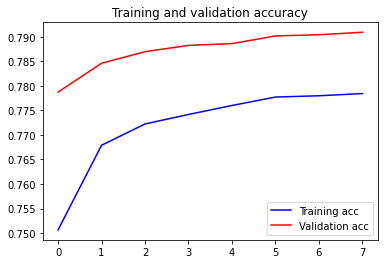

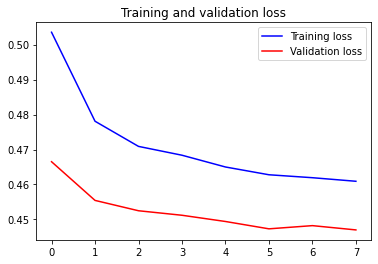

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [36]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [37]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [38]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9837759733200073,
 'elapsed_time': 0.4949796199798584}

In [55]:
predict("I am not happy")

{'label': 'POSITIVE',
 'score': 0.8216348886489868,
 'elapsed_time': 0.051543474197387695}

In [56]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


40/40 [==============================] - 204s 5s/step
CPU times: total: 26min 26s
Wall time: 3min 24s


In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

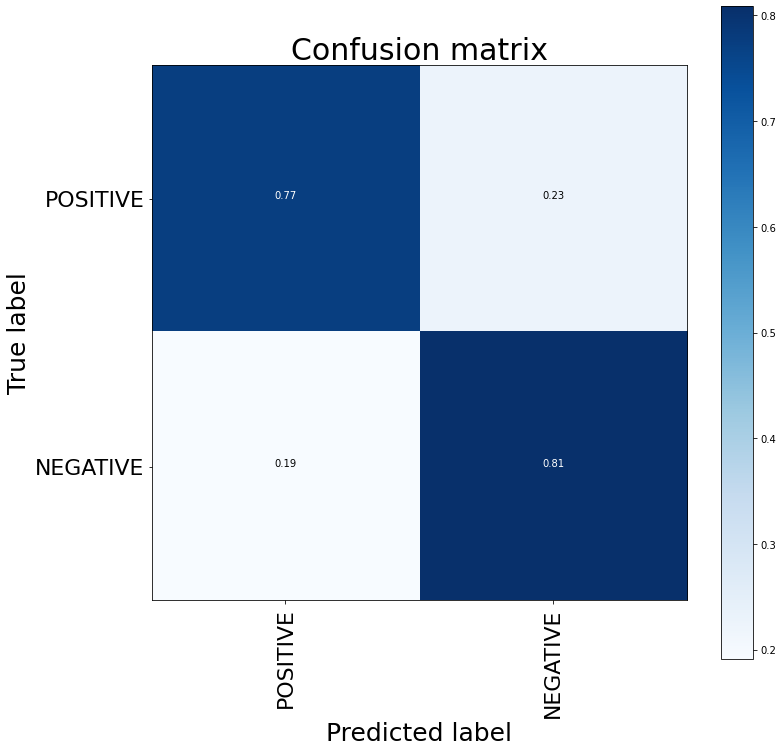

CPU times: total: 1.27 s
Wall time: 1.42 s


In [58]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [59]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.79    159494
    POSITIVE       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.79119375

In [61]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-02-16 11:39:10,861 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-16T11:39:10.861398', 'gensim': '4.1.2', 'python': '3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'saving'}
2022-02-16 11:39:10,897 : INFO : not storing attribute cum_table
2022-02-16 11:39:11,723 : INFO : saved model.w2v
